In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import warnings
from sklearn.svm import SVC
warnings.filterwarnings("ignore")

In [101]:
#讀入數據
cs_b = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
cs_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [102]:
#增加y
cs_b['Streaming'] = cs_b['StreamingTV'].replace("No", 0).replace("Yes", 1).replace("No internet service", 0)+cs_b['StreamingMovies'].replace("No", 0).replace("Yes", 1).replace("No internet service", 0)

cs_b.loc[cs_b['Streaming']==2, 'Streaming'] =1
cs_b.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Streaming
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [103]:
#有些空值‘ ’看不出來
cs_b['TotalCharges'] = cs_b['TotalCharges'].replace(' ', 0)
cs_b['TotalCharges'] = cs_b['TotalCharges'].astype(float)
cs_b.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Streaming
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [104]:
#因為已經有index, 所以把Customerid drop
cs_b = cs_b.drop(['customerID', 'StreamingTV', 'StreamingMovies'], axis=1)
cs_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null object
Streaming           7043 non-null int64
dtypes: float64(2), int64(3), object(14)
memory usage: 1.0+ MB


In [105]:
#先處理類別型feature, 再處理數字型
#將類別資料進行one hot encoding
#針對yes, no直接用0, 1取代
#nunique()的功能是計算unique的數目

category_columns = [c for c in cs_b.columns if cs_b[c].dtype == 'object' or c=='SeniorCitizen' or c == 'Streaming']
cs_category = cs_b[category_columns].copy()
for col in category_columns:
    if cs_category[col].nunique()==2:
        cs_category[col], _ = pd.factorize(cs_category[col])
    else:
        cs_category = pd.get_dummies(cs_category, columns = [col])
cs_category.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,Streaming,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
2,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0
4,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


In [106]:
num_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
cs_b[num_columns].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


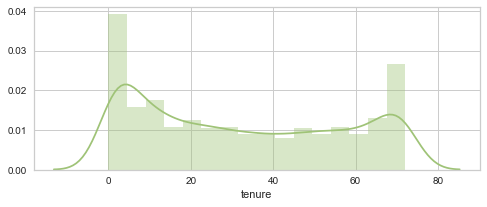

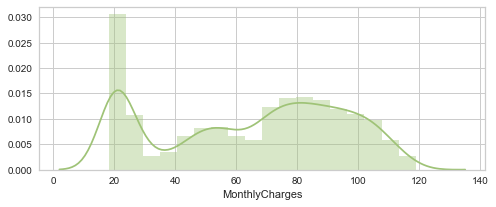

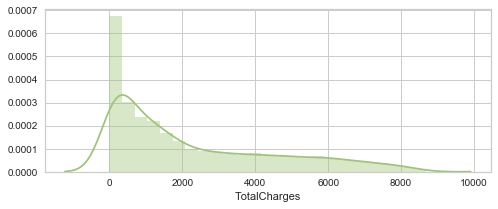

In [107]:
def histplot(feature, frame, color = 'g'):
    plt.figure(figsize=(8, 3))
    ax = sns.distplot(frame[feature], color = color)
    
for col in num_columns: histplot(col, cs_b)

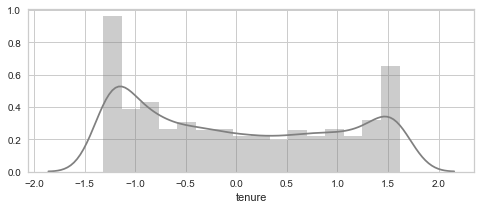

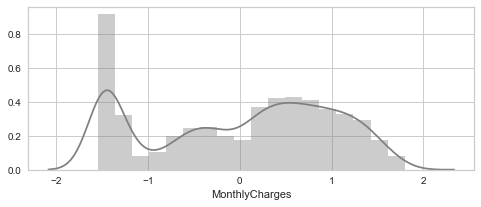

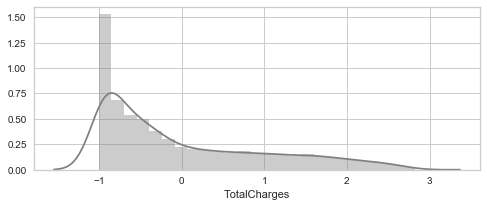

In [108]:
#standalization
df_std = pd.DataFrame(StandardScaler().fit_transform(cs_b[num_columns].astype('float64')),
                       columns=num_columns)
for col in num_columns: histplot(col, df_std, color='gray')

In [109]:
pd.set_option('display.max_columns', None)

cs_b_c = pd.concat([df_std, cs_category], axis=1)
metrics = ['roc_auc', 'accuracy']
cs_b_c.head()

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,Streaming,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.277445,-1.160323,-0.992611,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0
1,0.066327,-0.259629,-0.172165,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
2,-1.236724,-0.362660,-0.958066,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1
3,0.514251,-0.746535,-0.193672,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0
4,-1.236724,0.197365,-0.938874,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


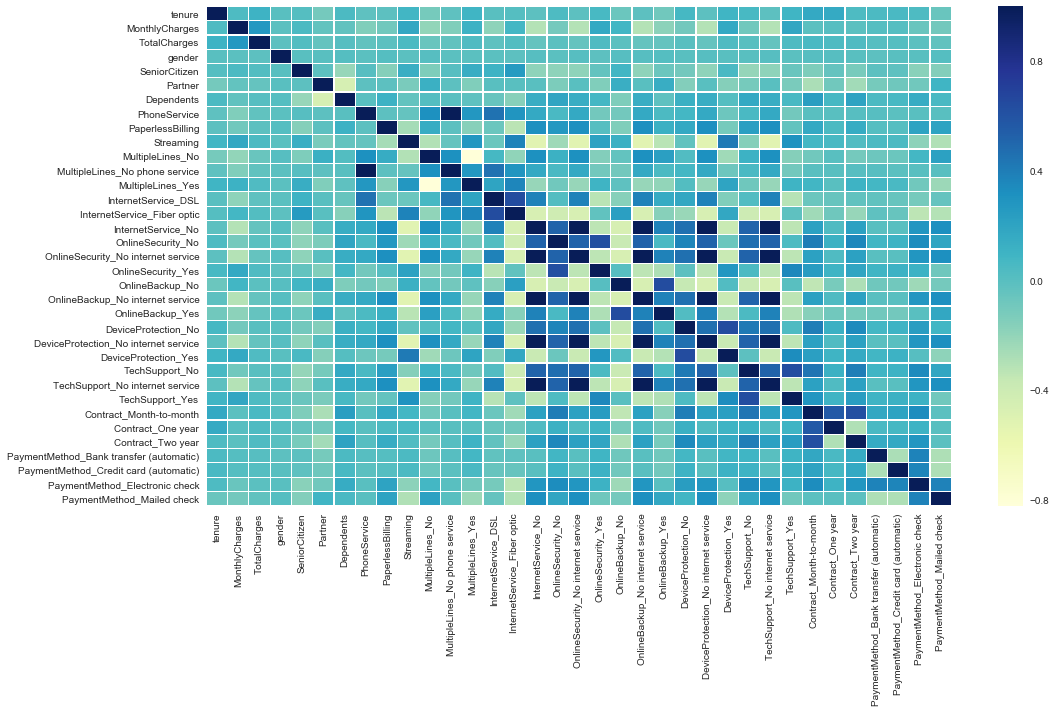

In [110]:
plt.figure(figsize=(16, 10))
cs_b_c.drop(['Churn'],
        axis=1, inplace=True)

corr = cs_b_c.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")
plt.tight_layout()
plt.savefig('heatmap_3.png')

In [117]:
#define X and y
#建立包含cross_validation及train/test split的資料集function
class Model():
    def __init__(self, classifier, frame, metrics, fixed_params = {},
                 test_size=0.2, random_seed=50):
        self.estimator = classifier
        self.seed = random_seed
        self.metrics = metrics
        self.hyperparameters = {}
        self.fixed_params = fixed_params
        self.fixed_params['random_state'] = random_seed
        if classifier == KNeighborsClassifier:
            del self.fixed_params['random_state']

        # First divide data in learning set and final test set
        self.train, self.test = train_test_split(frame, test_size=test_size, random_state= self.seed)
        self.predictors = [c for c in self.train.columns if c not in ['Streaming']]

    def grid_search(self, fit_metric, params, num_folds=10):
        """ Save the best params to self.hyperparameters. """
        print(self.fixed_params)
        gs = GridSearchCV(self.estimator(**self.fixed_params), param_grid= params,
                          scoring=self.metrics, cv=num_folds, refit= fit_metric)
        gs.fit(self.train[self.predictors], self.train['Streaming'])
        self.hyperparameters = gs.best_params_
        return [(m, gs.cv_results_['mean_test_{}'.format(m)][gs.best_index_]) for m in self.metrics]
    
    def train_and_evaluate_test(self):
        """ Train classifier on the full train set and evaluate the performance on the test set. """
        params = {**self.hyperparameters, **self.fixed_params}
        clf = self.estimator(**params).fit(self.train[self.predictors], self.train['Streaming'])
        y_pred = clf.predict(self.test[self.predictors])
        y_prob = clf.predict_proba(self.test[self.predictors])[:, 1]
        results = list()
        for m in self.metrics:
            if m == 'roc_auc':
                # For calculating roc auc we need the probability of target==1
                results.append((m, roc_auc_score(self.test['Streaming'], y_prob)))
            else:
                # For the other metrics we can simply use the predicted label (0 or 1)
                results.append((m, eval("{}_score".format(m))(self.test['Streaming'], y_pred)))
        return results

def print_result(results, sufix = ""):
    """ Function for printing the results nicely. """
    msg = ""
    for result in results:
        msg += "| {}: {:.4f} ".format(result[0], result[1])
    print("{}- {}".format(msg, sufix))


In [118]:
def logistic_regression(frame, grid):
    logit = Model(LogisticRegression, frame, metrics)
    print_result(logit.grid_search('roc_auc', grid), "cross-validation")
    print_result(logit.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", logit.hyperparameters)
logistic_regression(cs_b_c, {'C': np.logspace(-4, 4, 100, base=10)})

{'random_state': 50}
| roc_auc: 1.0000 | accuracy: 0.9993 - cross-validation
| roc_auc: 1.0000 | accuracy: 1.0000 - test set
Best hyperparameters: {'C': 0.3593813663804629}


In [67]:
logit_grid = {'C': np.linspace(0.02, 3, 150)}
logistic_regression(cs_b_c, logit_grid)

{'random_state': 50}
| roc_auc: 1.0000 | accuracy: 0.9991 - cross-validation
| roc_auc: 1.0000 | accuracy: 1.0000 - test set
Best hyperparameters: {'C': 0.34}


In [100]:
# Grid-search following second reference suggestions
def svc_rbf(frame, grid):
    rbf = Model(SVC, frame, metrics, fixed_params= {'kernel': 'rbf', 'probability': True})
    print_result(rbf.grid_search('roc_auc', grid, num_folds=4), "cross-validation")
    print_result(rbf.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", rbf.hyperparameters)

grid_rbf =  {'C': np.logspace(-4, 1, 10, base=2), 'gamma': np.logspace(-6, 2, 10, base=2)}
svc_rbf(cs_b_c, grid_rbf)

{'kernel': 'rbf', 'probability': True, 'random_state': 50}
| roc_auc: 1.0000 | accuracy: 0.9993 - cross-validation
| roc_auc: 1.0000 | accuracy: 1.0000 - test set
Best hyperparameters: {'C': 1.3607900001743771, 'gamma': 0.015625}


In [101]:
def svc_linear(frame, grid):
    linear = Model(SVC, frame, metrics, fixed_params={'kernel': 'linear', 'probability': True})
    print_result(linear.grid_search('roc_auc', grid), "cross-validation")
    print_result(linear.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", linear.hyperparameters)
svc_linear(cs_b_c, {'C': np.logspace(-4, 1, 100, base=10)})

{'kernel': 'linear', 'probability': True, 'random_state': 50}
| roc_auc: 1.0000 | accuracy: 0.9991 - cross-validation
| roc_auc: 1.0000 | accuracy: 1.0000 - test set
Best hyperparameters: {'C': 0.029836472402833405}


In [102]:
def svc_poly(frame, grid):
    poly_svc = Model(SVC, frame, metrics, fixed_params={'kernel': 'poly', 'probability': True})
    print_result(poly_svc.grid_search('roc_auc', grid), "cross-validation")
    print_result(poly_svc.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", poly_svc.hyperparameters)
svc_poly(cs_b_c, {'C': np.logspace(-5, 1, 30, base=2), 'degree': [2, 3]})

{'kernel': 'poly', 'probability': True, 'random_state': 50}
| roc_auc: 0.9984 | accuracy: 0.9812 - cross-validation
| roc_auc: 0.9993 | accuracy: 0.9865 - test set
Best hyperparameters: {'C': 2.0, 'degree': 2}


In [103]:
def knn_clf(frame, grid):
    knn = Model(KNeighborsClassifier, frame, metrics)
    print_result(knn.grid_search('roc_auc', grid), "cross-validation")
    print_result(knn.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", knn.hyperparameters)
knn_clf(cs_b_c, {'n_neighbors': [i for i in range(10, 50, 2)]})

{}
| roc_auc: 0.9223 | accuracy: 0.8348 - cross-validation
| roc_auc: 0.9203 | accuracy: 0.8382 - test set
Best hyperparameters: {'n_neighbors': 32}
